# Analysis: XGBoost for Profitability

Goal: Use XGBoost to create a model classifying the profitable feature.

In [82]:
import pandas as pd
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pd.set_option('display.max_rows', 100);

In [4]:
%load_ext autoreload

import sys
sys.path.append('../')
import plot_confusion_matrix as pcm;

## Prepare Target & Features
Dropped 'volume' and 'weight' since they have many nulls and are collinear.  
Dropped arbitrary details contained in 'set_no' and 'name'.  
Dropped price data used to create the target.  
Dropped popularity because it reflects future perception not info available at the time of release.  
Dropped number of unique parts by category columns since we already have the total by category and wanted to prevent redundancy in the signal provided by those features. The total pieces per set were kept since the category breakdowns were dropped, but the total unique parts per set were dropped since their category breakdowns were kept. The intent of this was to reduce dimensionality and collinearity to hopefully improve model results and generalizability.

In [5]:
FEATURE_FILE = '../data/merge_feature.csv'
full_df = pd.read_csv(FEATURE_FILE)

In [6]:
drop_category_nmbr_cnts = [s for s in list(full_df.columns) if '_cnt_prts' in s]

In [7]:
feat_df = full_df.drop(columns=['set_no', 'name',  'price_store', 'price_used',
                                'volume', 'weight', 'total_parts','number_spare_parts',
                                'popularity', 'aftermarket', 'adj_store_price',
                                'adj_aftermarket']+drop_category_nmbr_cnts)

# filter out rows without profitable (i.e. target), and the few without primary/secondary colors
feat_df.dropna(axis=0,
               subset=['profitable', 'scolor_1st', 'scolor_2nd'],
               inplace=True)

# feat_df.head()

,year,number_parts,total_spare_parts,number_colors,bars_ladders_and_fences_tot_prts,baseplates_tot_prts,belville_scala_and_fabuland_tot_prts,bionicle_hero_factory_and_constraction_tot_prts,bricks_tot_prts,bricks_curved_tot_prts,...,transportation_-_sea_and_air_tot_prts,tubes_and_hoses_tot_prts,wheels_and_tyres_tot_prts,windows_and_doors_tot_prts,windscreens_and_fuselage_tot_prts,znap_tot_prts,category,scolor_1st,scolor_2nd,profitable
4,1984,30,0,7,2,1,8,0,21,2,...,0,0,0,3,0,0,Bigfig-Junior,Yellow,Red,1.0
5,1984,34,2,8,2,1,6,0,8,0,...,3,0,0,7,0,0,Bigfig-Junior,Yellow,Red,1.0
8,1984,26,0,8,0,0,0,0,1,0,...,0,0,2,0,0,0,Historical,Black,Red,1.0
9,1984,30,4,8,0,0,0,0,2,0,...,0,0,0,0,0,0,Historical,Black,Blue,1.0
10,1984,30,0,7,0,0,0,0,6,0,...,0,0,2,0,0,0,Historical,Black,Red,1.0


In [8]:
# confirmed no nulls
# feat_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3824 entries, 4 to 4921
Data columns (total 65 columns):
year                                                3824 non-null int64
number_parts                                        3824 non-null int64
total_spare_parts                                   3824 non-null int64
number_colors                                       3824 non-null int64
bars_ladders_and_fences_tot_prts                    3824 non-null int64
baseplates_tot_prts                                 3824 non-null int64
belville_scala_and_fabuland_tot_prts                3824 non-null int64
bionicle_hero_factory_and_constraction_tot_prts     3824 non-null int64
bricks_tot_prts                                     3824 non-null int64
bricks_curved_tot_prts                              3824 non-null int64
bricks_printed_tot_prts                             3824 non-null int64
bricks_round_and_cones_tot_prts                     3824 non-null int64
bricks_sloped_tot_prts       

In [9]:
# target series
target = feat_df['profitable']
print(target.shape)

# initial features
features = feat_df.drop(columns=['profitable'])
print(features.shape)

(3824,)
(3824, 64)


In [10]:
# feature dataframe with one-hot encoding
features = pd.get_dummies(features, drop_first= True,
                          columns=['category', 'scolor_1st', 'scolor_2nd'])
features.shape

(3824, 92)

## Train-Test Split

In [11]:
TEST_SPLIT = 0.2
SEED = 0

In [12]:
y_train, y_test, X_train, X_test = train_test_split(target, features,
                                                    stratify=features['year'],
                                                    test_size=TEST_SPLIT, random_state=SEED)

print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

(3059,)
(765,)
(3059, 92)
(765, 92)


## PCA Analysis
We implemented Principal Component Analysis (PCA) to see if we could simplify the model and help it generalize well. We identified the number of parameters that explained 95% of the variance below, but during the modeling we also tried other levels. None ultimately proved fruitful. While the count of parameters may represent a different level of explained variance within each fold of the cross validation or the testing data used later in the notebook this was seen as an acceptable approximation. The cumulative explained variance plot showed the promise of being able to reduce dimensionality to improve the speed of the hyperparameter grid search, and we had hoped generalizability as well.

In [13]:
# standardizing data
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

In [14]:
# Initial full PCA of features
pca = PCA(random_state=SEED)
x_pca = pca.fit_transform(X_train_std)

In [15]:
# defining count of PCA features to capture 95% of variance from entire train set
PCA_COUNT = sum(pca.explained_variance_ratio_.cumsum() < .95) + 1
print(PCA_COUNT)
PCA_EXPLAINED_VAR = pca.explained_variance_ratio_.cumsum()[PCA_COUNT-1]
print(PCA_EXPLAINED_VAR)

66
0.9522254515489256


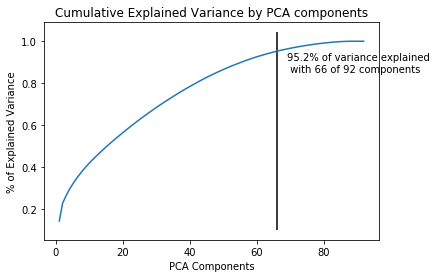

In [16]:
# plotting PCA cumulative explained variance.
feat_cnt = X_train.shape[1]
plt.plot(range(1,feat_cnt+1), pca.explained_variance_ratio_.cumsum())

ax = plt.gca()
ax.set_xlabel("PCA Components")
ax.set_ylabel("% of Explained Variance")
ax.set_title("Cumulative Explained Variance by PCA components")

ax.vlines(x=PCA_COUNT, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])
ax.annotate(f'{round(100*PCA_EXPLAINED_VAR,1)}% of variance explained \n with {PCA_COUNT} of {feat_cnt} components',
            xy=[PCA_COUNT, PCA_EXPLAINED_VAR],
            xytext=[PCA_COUNT+3, PCA_EXPLAINED_VAR-0.1]);

## GridSearchCV with XGBoost and Pipeline of Scaling - Baseline
A Baseline model is fit with all the parameter and standard scaling. Accuracy is ok, but the significant increase between the CV accuracy and accuracy on the entire training set makes us believe our model may be over fit. Attempts will be made to reduce the features to account for this.

In [65]:
# calculating class ratio for XGBoost balancing
class_pos_rate = len(y_train[y_train==0]) / len(y_train[y_train==1])
class_pos_rate

2.814214463840399

In [18]:
# establishing the model
pipe = Pipeline([("scaler", StandardScaler()),
                 ("xgb", XGBClassifier(random_state=SEED,
                                       scale_pos_weight=class_pos_rate))])

# The original parameter grid is replaced with its resulting selection to speed up the notebook
# param_grid = {'xgb__learning_rate': [0.1, 0.15, 0.2],
#               'xgb__max_depth': [3, 6, 9],
#               'xgb__min_child_weight': [1, 2, 3],
#               'xgb__subsample': [0.75, 0.85, 1],
#               'xgb__n_estimators': [100, 150, 200]}

param_grid = {'xgb__learning_rate': [0.2],
              'xgb__max_depth': [9],
              'xgb__min_child_weight': [1],
              'xgb__subsample': [0.85],
              'xgb__n_estimators': [150]}

grid_clf = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=3)

In [19]:
grid_clf.fit(X_train, y_train);

In [20]:
grid_clf_results = pd.DataFrame(grid_clf.cv_results_)
grid_clf.best_score_

0.7933965348152991

In [33]:
# observing grid search results
best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
training_accuracy = accuracy_score(y_train, training_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))

Grid Search found the following optimal parameters: 
xgb__learning_rate: 0.2
xgb__max_depth: 9
xgb__min_child_weight: 1
xgb__n_estimators: 150
xgb__subsample: 0.85

Training Accuracy: 99.57%


## GridSearchCV with XGBoost and Pipeline of Scaling and PCA
PCA was seen to result in an unacceptable loss in CV score even when high %'s of explained variance were accounted for. It did not appear to help with potential over-fitting. And will not be pursued further.

In [22]:
pca_pipe = Pipeline([("scaler", StandardScaler()),
                     ("pca", PCA(n_components=PCA_COUNT,
                                 random_state=SEED)),
                     ("xgb", XGBClassifier(random_state=SEED,
                                           scale_pos_weight=class_pos_rate))])

# The original parameter grid is replaced with its resulting selection to speed up the notebook
# param_grid = {'xgb__learning_rate': [0.1, 0.15, 0.2],
#               'xgb__max_depth': [3, 6, 9],
#               'xgb__min_child_weight': [1, 2, 3],
#               'xgb__subsample': [0.75, 0.85, 1],
#               'xgb__n_estimators': [100, 150, 200]}

param_grid = {'xgb__learning_rate': [0.2],
              'xgb__max_depth': [9],
              'xgb__min_child_weight': [2],
              'xgb__subsample': [0.85],
              'xgb__n_estimators': [200]}

pca_clf = GridSearchCV(pca_pipe, param_grid, scoring='accuracy', cv=3)

In [23]:
pca_clf.fit(X_train, y_train);

In [24]:
pca_clf_results = pd.DataFrame(pca_clf.cv_results_)
pca_clf.best_score_

0.7692056227525335

In [25]:
pca_best_params = pca_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(pca_best_params.keys()):
    print("%s: %r" % (param_name, pca_best_params[param_name]))

pca_training_preds = pca_clf.predict(X_train)
pca_training_accuracy = accuracy_score(y_train, pca_training_preds)

print("")
print("Training Accuracy: {:.4}%".format(pca_training_accuracy * 100))

Grid Search found the following optimal parameters: 
xgb__learning_rate: 0.2
xgb__max_depth: 9
xgb__min_child_weight: 2
xgb__n_estimators: 200
xgb__subsample: 0.85

Training Accuracy: 99.77%


## GridSearchCV with XGBoost and Pipeline of Scaling and SMOTE Oversampling
SMOTE was incorporated into the pipeline to account for the class imbalance. While it showed increased an increased CV score here, it was often observed to decrease the scores slightly in other iterations of the model (i.e. with different parameter grids, different scoring metrics, with PCA, etc.). It will be implemented in parallel to a non-SMOTE model and they will be evaluated at the testing phase.

In [26]:
smote_pipe = Pipeline([("scaler", StandardScaler()),
                       ("smote", SMOTE(random_state=SEED)),
                       ("xgb", XGBClassifier(random_state=SEED))])

# The original parameter grid is replaced with its resulting selection to speed up the notebook
# param_grid = {'xgb__learning_rate': [0.1, 0.15, 0.2],
#               'xgb__max_depth': [3, 6, 9],
#               'xgb__min_child_weight': [1, 2, 3],
#               'xgb__subsample': [0.75, 0.85, 1],
#               'xgb__n_estimators': [100, 150, 200]}

param_grid = {'xgb__learning_rate': [0.1],
              'xgb__max_depth': [9],
              'xgb__min_child_weight': [1],
              'xgb__subsample': [1],
              'xgb__n_estimators': [100]}

smote_grid_clf = GridSearchCV(smote_pipe, param_grid, scoring='accuracy', cv=3)

In [27]:
smote_grid_clf.fit(X_train, y_train);

In [28]:
smote_grid_clf_results = pd.DataFrame(smote_grid_clf.cv_results_)
smote_grid_clf.best_score_

0.7950310559006211

In [29]:
smote_best_parameters = smote_grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(smote_best_parameters.keys()):
    print("%s: %r" % (param_name, smote_best_parameters[param_name]))

smote_training_preds = smote_grid_clf.predict(X_train)
smote_training_accuracy = accuracy_score(y_train, smote_training_preds)

print("")
print("Training Accuracy {:.4}%".format(smote_training_accuracy * 100))

Grid Search found the following optimal parameters: 
xgb__learning_rate: 0.1
xgb__max_depth: 9
xgb__min_child_weight: 1
xgb__n_estimators: 100
xgb__subsample: 1

Training Accuracy 99.08%


## Identifying Most Influential Features from Baseline
Features were sorted by their importance in the baseline model. While this isn't a perfect ordering of importance it was seen as better than a random guess and a quick way to isolate more important features.  
  
Future work on this project would include improving the methodology for selecting the best parameters. Perhaps through backward selection of the ultimately selected subset of features, and potentially on-by-one forward selection of the out of set features to see if one may improve the model even if those higher on the list hadn't.

In [30]:
importance_df = pd.DataFrame.from_dict(dict(zip(list(X_train.columns),
                                                list(grid_clf.best_estimator_
                                                             .named_steps["xgb"]
                                                            .feature_importances_))),
                                       orient='index')
importance_df.columns = ["importance"]

In [31]:
importance_df = importance_df.sort_values(by="importance",
                                          ascending=False)
importance_df

,importance
category_Historical,0.107342
category_Licensed-Movie,0.040536
category_Licensed-Other,0.032610
category_Bigfig-Girls,0.031346
mechanical_tot_prts,0.025208
category_Constraction,0.023480
category_Licensed-StarWars,0.021591
other_tot_prts,0.021505
wheels_and_tyres_tot_prts,0.018199
category_Sports,0.018093


In [54]:
top_feats = list(importance_df.head(71).index)
X_train_subset = X_train[top_feats]
X_test_subset = X_test[top_feats]

## GridSearchCV with XGBoost and Pipeline of Scaling with Most Important Features
The model was fit on the top 20 features and then additional features were added to the subset one at a time and the subset with the top CV score was chosen as the final model. This included the top 71 features from the baseline model and showed 0.5% improvement in accuracy.  
  
The reduction in features will hopefully decrease the risk of over-fitting which was observed through the high training scores when the model was fit to the entirety of the training data.

In [57]:
impt_pipe = Pipeline([("scaler", StandardScaler()),
                      ("xgb", XGBClassifier(random_state=SEED,
                                            scale_pos_weight=class_pos_rate))])

# The original parameter grid is replaced with its resulting selection to speed up the notebook
# param_grid = {'xgb__learning_rate': [0.1, 0.15, 0.2],
#               'xgb__max_depth': [3, 6, 9],
#               'xgb__min_child_weight': [1, 2, 3],
#               'xgb__subsample': [0.75, 0.85, 1],
#               'xgb__n_estimators': [100, 150, 200]}

param_grid = {'xgb__learning_rate': [0.1],
              'xgb__max_depth': [9],
              'xgb__min_child_weight': [1],
              'xgb__subsample': [0.85],
              'xgb__n_estimators': [200]}

impt_clf = GridSearchCV(impt_pipe, param_grid, scoring='accuracy', cv=3)

In [58]:
impt_clf.fit(X_train_subset, y_train);

In [59]:
impt_clf_results = pd.DataFrame(impt_clf.cv_results_)
impt_clf.best_score_

0.7986270022883295

In [60]:
impt_best_parameters = impt_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(impt_best_parameters.keys()):
    print("%s: %r" % (param_name, impt_best_parameters[param_name]))

impt_training_preds = impt_clf.predict(X_train_subset)
impt_training_accuracy = accuracy_score(y_train, impt_training_preds)

print("")
print("Training Accuracy: {:.4}%".format(impt_training_accuracy * 100))

Grid Search found the following optimal parameters: 
xgb__learning_rate: 0.1
xgb__max_depth: 9
xgb__min_child_weight: 1
xgb__n_estimators: 200
xgb__subsample: 0.85

Training Accuracy: 99.64%


## GridSearchCV with XGBoost and Pipeline of Scaling and SMOTE with Most Important Features
The previous model was also checked with SMOTE, but it didn't perform as well.

In [61]:
impt_smote_pipe = Pipeline([("scaler", StandardScaler()),
                      ("smote", SMOTE(random_state=SEED)),
                      ("xgb", XGBClassifier(random_state=SEED))])

# The original parameter grid is replaced with its resulting selection to speed up the notebook
# param_grid = {'xgb__learning_rate': [0.1, 0.15, 0.2],
#               'xgb__max_depth': [3, 6, 9],
#               'xgb__min_child_weight': [1, 2, 3],
#               'xgb__subsample': [0.75, 0.85, 1],
#               'xgb__n_estimators': [100, 150, 200]}

param_grid = {'xgb__learning_rate': [0.1],
              'xgb__max_depth': [9],
              'xgb__min_child_weight': [1],
              'xgb__subsample': [0.85],
              'xgb__n_estimators': [200]}

impt_smote_clf = GridSearchCV(impt_smote_pipe, param_grid, scoring='accuracy', cv=3)

In [62]:
impt_smote_clf.fit(X_train_subset, y_train);

In [63]:
impt_smote_clf_results = pd.DataFrame(impt_smote_clf.cv_results_)
impt_smote_clf.best_score_

0.7966655769859431

In [64]:
impt_smote_best_parameters = impt_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(impt_smote_best_parameters.keys()):
    print("%s: %r" % (param_name, impt_smote_best_parameters[param_name]))

impt_smote_training_preds = impt_smote_clf.predict(X_train_subset)
impt_smote_training_accuracy = accuracy_score(y_train, impt_smote_training_preds)

print("")
print("Training Accuracy: {:.4}%".format(impt_smote_training_accuracy * 100))

Grid Search found the following optimal parameters: 
xgb__learning_rate: 0.1
xgb__max_depth: 9
xgb__min_child_weight: 1
xgb__n_estimators: 200
xgb__subsample: 0.85

Training Accuracy: 96.53%


## Testing
Attempts were made to optimize the model to increase the F1 score, but it was observed to significantly increase recall while also decreasing precision. While it was nice that it produced many more true positives, it did so at an unacceptable loss in precision, so accuracy was maintained as the key metric.

The final model with only the important features performed best. Future efforts to improve the model should include more robust attempts at identifying the most important features, so over-fitting can be mitigated.

In [72]:
val_preds = grid_clf.predict(X_test)
val_accuracy = accuracy_score(y_test, val_preds)

pca_val_preds = pca_clf.predict(X_test)
pca_val_accuracy = accuracy_score(y_test, pca_val_preds)

smote_val_preds = smote_grid_clf.predict(X_test)
smote_val_accuracy = accuracy_score(y_test, smote_val_preds)

impt_val_preds = impt_clf.predict(X_test_subset)
impt_val_accuracy = accuracy_score(y_test, impt_val_preds)

impt_smote_val_preds = impt_smote_clf.predict(X_test_subset)
impt_smote_val_accuracy = accuracy_score(y_test, impt_smote_val_preds)

print("XGBoost Baseline Validation Accuracy: {:.4}%".format(val_accuracy * 100))
print("")
print("XGBoost w/ PCA Validation Accuracy: {:.4}%".format(pca_val_accuracy * 100))
print("")
print("XGBoost w/ SMOTE Validation Accuracy: {:.4}%".format(smote_val_accuracy * 100))
print("")
print("XGBoost w/ Most Important Features Validation Accuracy: {:.4}%".format(impt_val_accuracy * 100))
print("")
print("XGBoost w/ Most Important Features & SMOTE Validation Accuracy: {:.4}%".format(impt_smote_val_accuracy * 100))
print("")
print("Accuracy Assuming None Profitable: {:.4}%".format(len(y_test[y_test==0]) / len(y_test) * 100))

XGBoost Baseline Validation Accuracy: 80.0%

XGBoost w/ PCA Validation Accuracy: 79.48%

XGBoost w/ SMOTE Validation Accuracy: 79.87%

XGBoost w/ Most Important Features Validation Accuracy: 81.31%

XGBoost w/ Most Important Features & SMOTE Validation Accuracy: 80.52%

Accuracy Assuming None Profitable: 72.16%


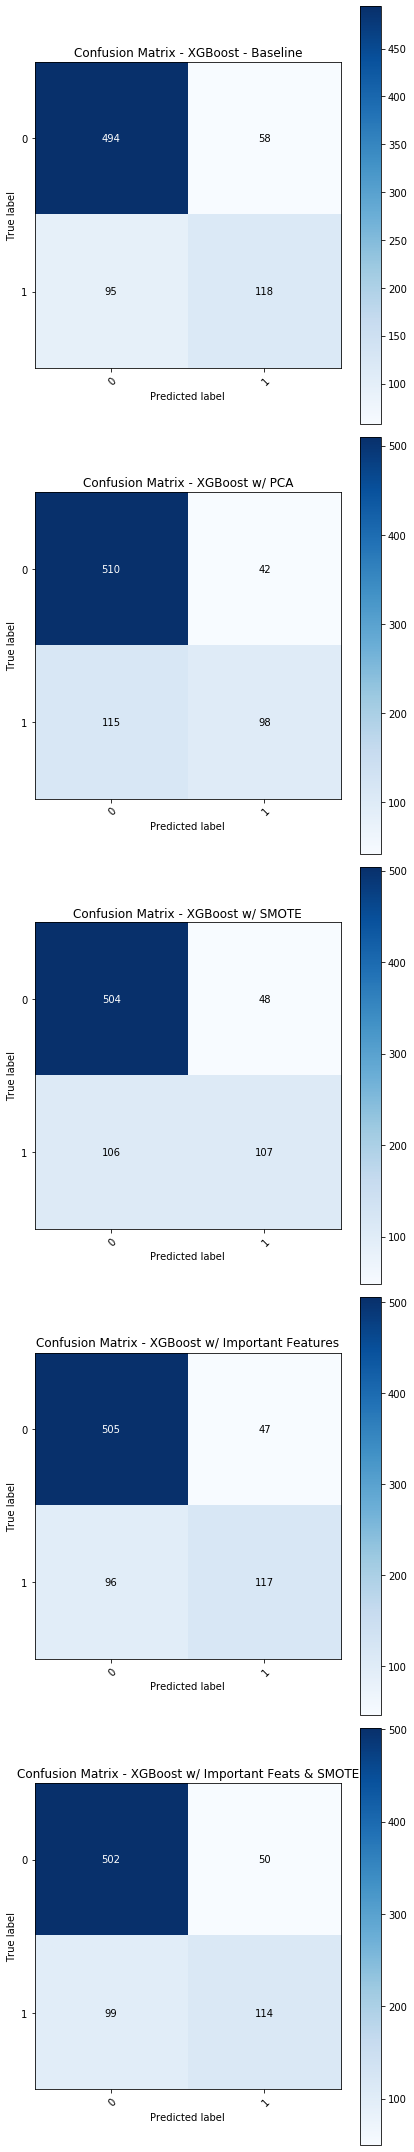

In [76]:
#plotting confusion matrices
fig, axes = plt.subplots(5, 1, figsize=(6,30))

pcm.plot_confusion_matrix(y_test.astype('int64'),
                          val_preds.astype('int64'),
                          title="Confusion Matrix - XGBoost - Baseline",
                          classes=np.array([0,1]),
                          figure=fig,
                          axis=axes[0])

pcm.plot_confusion_matrix(y_test.astype('int64'),
                          pca_val_preds.astype('int64'),
                          title="Confusion Matrix - XGBoost w/ PCA",
                          classes=np.array([0,1]),
                          figure=fig,
                          axis=axes[1])

pcm.plot_confusion_matrix(y_test.astype('int64'),
                          smote_val_preds.astype('int64'),
                          title="Confusion Matrix - XGBoost w/ SMOTE",
                          classes=np.array([0,1]),
                          figure=fig,
                          axis=axes[2])

pcm.plot_confusion_matrix(y_test.astype('int64'),
                          impt_val_preds.astype('int64'),
                          title="Confusion Matrix - XGBoost w/ Important Features",
                          classes=np.array([0,1]),
                          figure=fig,
                          axis=axes[3])

pcm.plot_confusion_matrix(y_test.astype('int64'),
                          impt_smote_val_preds.astype('int64'),
                          title="Confusion Matrix - XGBoost w/ Important Feats & SMOTE",
                          classes=np.array([0,1]),
                          figure=fig,
                          axis=axes[4])

# a bug in the current version of matplotlib shifts the default ylim,
# and the code below corrects it
axes[0].set_ylim(1.5, -0.5)
axes[1].set_ylim(1.5, -0.5)
axes[2].set_ylim(1.5, -0.5)
axes[3].set_ylim(1.5, -0.5)
axes[4].set_ylim(1.5, -0.5);